# Carry Trade Analysis


In [8]:
import os
import datetime
import quandl
import random

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import scipy as sp
import quandl
from sklearn.linear_model import LinearRegression



In [9]:
API_key_VX = "stqXZAdv9-_Dd2ZKAYFp"

In [10]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOMEPATH"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=API_key_VX, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )




In [11]:
fx_rates = fetch_quandl_table("EDI/CUR", avoid_download=False)

Data file \Users\vince\quandl_data_table_downloads\EDI/CUR_20250214.zip size 7929830 exists already, no need to download


In [12]:
inferred_rates = pd.read_csv('../data/InferredYieldCurves_2025-02-04.tab', sep='\t')

In [13]:
ois =  pd.read_csv("../data/BOE_spot.csv")
ois.index = pd.to_datetime(ois.Date)
ois = ois.sort_index()
ois = ois[ois.index >= '2010-01-06'][['1']] * 12 / 5200
# convert from month to annual rate

ois.head()



,1
Date,
2010-01-06,0.001031
2010-01-07,0.001023
2010-01-08,0.001031
2010-01-11,0.001030
2010-01-12,0.001023


In [16]:
fx_rates.head()

,code,date,rate
0,AED,2023-07-20,3.672900
1,AFN,2023-07-20,85.664367
2,ALL,2023-07-20,90.165179
3,AMD,2023-07-20,389.973810
4,ANG,2023-07-20,1.801893


In [15]:
inferred_rates.head()

,Unnamed: 0,shortname,tenor,date,yield
0,3401,Arab Rep Egypt,10Y,2010-01-04,0.075885
1,3402,Arab Rep Egypt,10Y,2010-01-05,0.074642
2,3403,Arab Rep Egypt,10Y,2010-01-06,0.074318
3,3404,Arab Rep Egypt,10Y,2010-01-07,0.073642
4,3405,Arab Rep Egypt,10Y,2010-01-08,0.073024


# Init functions


In [17]:
def get_rates(code_val):
    df = fx_rates[fx_rates.code == code_val]
    df.index = pd.to_datetime(df.date, format='%Y-%m-%d')
    df = df.sort_index()
    df = df[df.index >= '2010-01-06']
    return df[['rate']] / 100

def get_inferred_yc(shortname_val):
    df = inferred_rates[inferred_rates.shortname == shortname_val]
    df.index = pd.to_datetime(df.date, format='%Y-%m-%d')
    df = df[df.index >= '2010-01-06']
    df = df.sort_index()

    M6 = df[df.tenor == '6M']['yield']
    Y1 = df[df.tenor == '1Y']['yield']
    Y5 = df[df.tenor == '5Y']['yield']
    Y10 = df[df.tenor == '10Y']['yield']

    yc = pd.concat([M6, Y1, Y5, Y10], axis = 1)
    yc.columns = [0.5, 1, 5, 10]

    return yc


In [18]:
inferred_rates['shortname'].unique()
"""
Islamic Rep Pakistan
Rep South Africa
Rep Costa Rica
Rep Turkey
"""

'\nIslamic Rep Pakistan\nRep South Africa\nRep Costa Rica\nRep Turkey\n'

In [19]:
fx_rates['code'].unique()

'''
TRY
PKR
CRC
ZAR
'''

'\nTRY\nPKR\nCRC\nZAR\n'

In [58]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor in spot.index:  # Use .index instead of .iteritems()
            spot_rate = spot[tenor]
            if tenor > 0.001:
                times = np.arange(tenor - 0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5 * spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values)  # Linear interpolation
                preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
                zcb_rates.at[tenor, curve] = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor
    return zcb_rates

In [103]:
def bond_price(zcb_row, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]  # Semiannual payment times
    if times.shape[0] == 0:
        return 1.0  # If no payments, assume par value

    tenors = zcb_row.index.astype(float)  # Ensure tenors are numeric
    r = np.interp(times, tenors, zcb_row.values)  # Linear interpolation for discount rates

    # Compute bond price using discounted cash flows
    price = np.exp(-tenor * r[-1]) + 0.5 * coupon_rate * np.exp(-r * times).sum()
    return price

In [62]:
d = compute_zcb_curve(get_inferred_yc('Rep Turkey').T).T

In [66]:
test_row = d.iloc[0].copy()

test_row

0.5     0.009966
1.0     0.015166
5.0     0.050629
10.0    0.068629
Name: 2010-01-06 00:00:00, dtype: float64

In [67]:
bond_price(test_row, 0.05, 5)

1.0026979246850785

In [68]:
test_row.index = test_row.index - 1/52

print(test_row)
bond_price(test_row, 0.05, 5)

0.480769    0.009966
0.980769    0.015166
4.980769    0.050629
9.980769    0.068629
Name: 2010-01-06 00:00:00, dtype: float64


1.0023369210006434

In [121]:
def generate_merged_df(df_rates, df_swaps):
    zcb_df = compute_zcb_curve(df_swaps.T).T

    df_merged = df_rates.join(zcb_df, how='outer')
    df_merged['cpn rate'] = df_swaps[5.0]
    df_merged = df_merged.interpolate(method='linear')

    first_date = df_merged.index[0]
    df_merged = df_merged[(df_merged.index.to_series().map(lambda x: (x - first_date).days % 7 == 0))]

    df_merged = df_merged.astype(float)

    df_merged['last cpn rate'] = df_merged['cpn rate'].shift()

    
    
    def safe_bond_price(row):
        if row[[0.5, 1.0, 5.0, 10.0, 'last cpn rate']].isnull().any():
            return np.nan
        try:
            return bond_price(row[[0.5, 1.0, 5.0, 10.0]], row['last cpn rate'], 5 - 1/52)
        except Exception:
            return np.nan
        
    df_merged['bond price'] = df_merged.apply(safe_bond_price, axis=1)

    return df_merged[['rate', 'cpn rate', 'bond price']]

In [122]:
# test value
generate_merged_df(TR_rates, TR_swap).head()

,rate,cpn rate,bond price
date,,,
2010-01-06,0.014752,0.049329,NaN
2010-01-13,0.014492,0.047811,1.008188
2010-01-20,0.014695,0.047559,1.002427
2010-01-27,0.014944,0.049201,0.993860
2010-02-03,0.014855,0.049476,1.000056


In [123]:
rates_list = ['TRY', 'PKR', 'CRC', 'ZAR']
swap_list = ['Rep Turkey', 'Islamic Rep Pakistan', 'Rep Costa Rica', 'Rep South Africa']

r_df_list = []
s_df_list = []

merged_dict = {}

for name, s_name in zip(rates_list, swap_list):
    r_df_list.append(get_rates(name))
    s_df_list.append(get_inferred_yc(s_name))

for i, name in enumerate(rates_list):
    merged_dict[name] = generate_merged_df(r_df_list[i], s_df_list[i])



C:\Users\vince\AppData\Local\Temp\ipykernel_9700\375005611.py:12: RuntimeWarning: invalid value encountered in log
  zcb_rates.at[tenor, curve] = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor


# Main trading function

In the above functions, I have made a merged_dict dictionary that contains all of the fx rates and swap rates of the 4 specified currencies. Below, I will implement a strategy that trades pairs of these.

Trade logic:

if cpn rate of currency 1 is 50bps or more higher than cpn rate of currency 2:
    buy bonds in currency 1
    borrow currency 2

if it is in between values:
    no position

## PnL calculation

PnL of the lending currency in period t assuming a position was built in t - 1:

PnL1 = (bond price(t) - 1) * notional * (fx rate(t)) / (fx rate(t-1))

PnL of the borrowed currency in period t:

PnL2 = 0.8 * notional (OIS + 50 bps) / 52



In [143]:
def execute_trade_strat(df1, df2, name1, name2, df_ois=ois):
    """
    Parameters: 
        df1: merged dataframe for the first currency
        df2: merged dataframe for the second currency
        name1: first currency tag
        name2: second currency tag
        df_ois: df containing ois information
    """

    notional = 10_000_000
    lev = 5
    edge = 0.005

    r_name1 = f'{name1} fx rate'
    r_name2 = f'{name2} fx rate'
    r_prev1 = f'{name1} fx ratio'
    r_prev2 = f'{name2} fx ratio'
    s_name1 = f'{name1} cpn rate'
    s_name2 = f'{name2} cpn rate'
    b_name1 = f'{name1} bond price'
    b_name2 = f'{name2} bond price'

    df_mod1 = df1.rename(columns={'rate': r_name1, 'cpn rate': s_name1, 'bond price': b_name1})
    df_mod2 = df2.rename(columns={'rate': r_name2, 'cpn rate': s_name2, 'bond price': b_name2})

    first_date = df_ois.index[0]
    df_ois = df_ois[(df_ois.index.to_series().map(lambda x: (x - first_date).days % 7 == 0))]

    df_res = df_mod1.join(df_mod2, how='outer').join(df_ois, how='outer')
    df_res = df_res.rename(columns={'1': 'ois'})

    def pos_func(row):
        diff = row[s_name1] - row[s_name2]
        if diff > edge:
            return 1
        elif diff < -edge:
            return -1
        else:
            return 0

    df_res['pos'] = df_res.apply(lambda row: pos_func(row), axis = 1)
    df_res['prev_pos'] = df_res['pos'].shift()
    df_res[r_prev1] = df_res[r_name1] / df_res[r_name1].shift()
    df_res[r_prev2] = df_res[r_name2] / df_res[r_name2].shift()
    df_res['borrow'] = (df_res['ois'].shift() + edge) / 52

    def safe_PnL(row):
        if row.isnull().any():
            return np.nan
        try:
            if row['prev_pos'] == 1:
                # lend first currency
                pnl_lend = (row[b_name1] - 1) * notional * row[r_prev1]
                pnl_borrow = (1 - 1/lev) * notional * row['borrow'] * row[r_prev2]
            elif row['prev_pos'] == -1:
                # lend second currency
                pnl_lend = (row[b_name2] - 1) * notional * row[r_prev2]
                pnl_borrow = (1 - 1/lev) * notional * row['borrow'] * row[r_prev1]
            else:
                return 0

            return pnl_lend - pnl_borrow
        except Exception:
            return np.nan
        
    df_res['PnL'] = df_res.apply(lambda row: safe_PnL(row), axis=1)
    df_res['Cumulative PnL'] = df_res['PnL'].cumsum()

    return df_res

In [144]:
from itertools import combinations

all_pairs = list(combinations(merged_dict.keys(), 2))
res_dict = {}

for curr1, curr2 in all_pairs:
    res_dict[(curr1, curr2)] = execute_trade_strat(merged_dict[curr1], merged_dict[curr2], curr1, curr2)


In [155]:
def graph_pair(y_axis, x_axis='None', index=True, histogram=False):
    for key, val_df in res_dict.items():
        name = f'Pair {key}'
        
        if histogram:
            plt.figure(figsize=(8, 5))
            plt.hist(val_df[y_axis].dropna(), bins=50, color='blue', alpha=0.7, edgecolor='black')
            plt.xlabel(y_axis)
            plt.ylabel("Frequency")
            plt.title(f'Histogram of {y_axis} for {name}')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
        else:
            if index:
                mod_df = val_df[[y_axis]].dropna()
                x_val = mod_df.index
                plot_name = f'{name}: {y_axis} vs Date'
            else:
                mod_df = val_df[[x_axis, y_axis]].dropna()
                x_val = mod_df[x_axis]
                plot_name = f'{name}: {y_axis} vs {x_axis}'

            y_val = mod_df[y_axis]

            plt.scatter(x_val, y_val)
            plt.plot(x_val, y_val, linestyle='-')

            plt.xlabel(x_axis if index else 'Date')
            plt.ylabel(y_axis)

            plt.title(plot_name)

            plt.legend()
            plt.grid()

            plt.show()



# Observing Cumulative PnL for all possible pairings

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


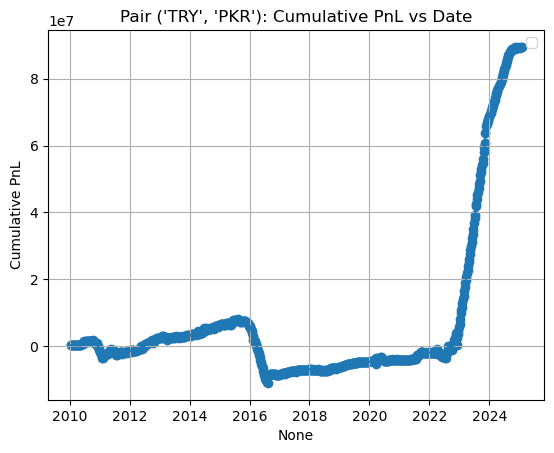

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


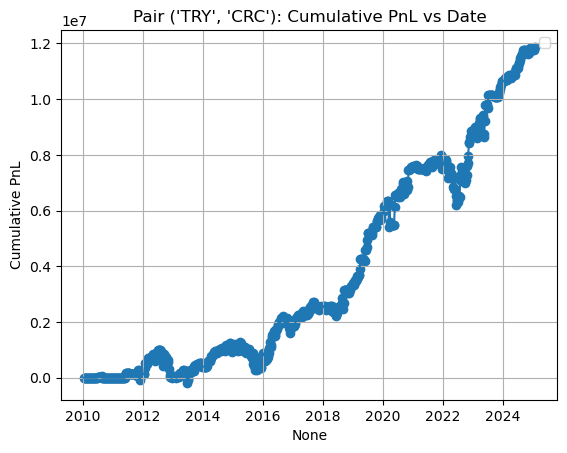

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


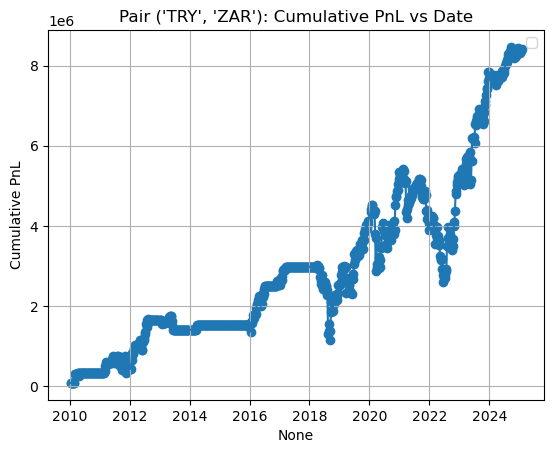

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


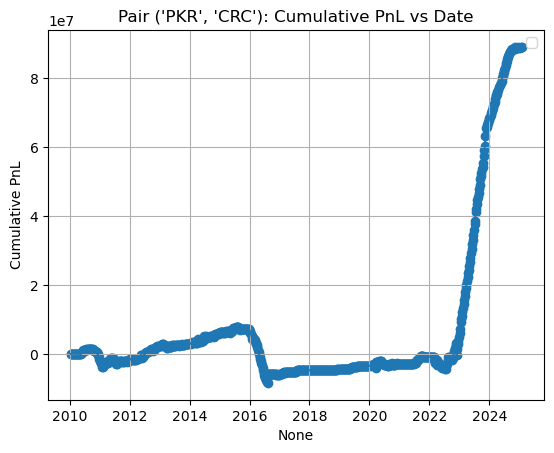

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


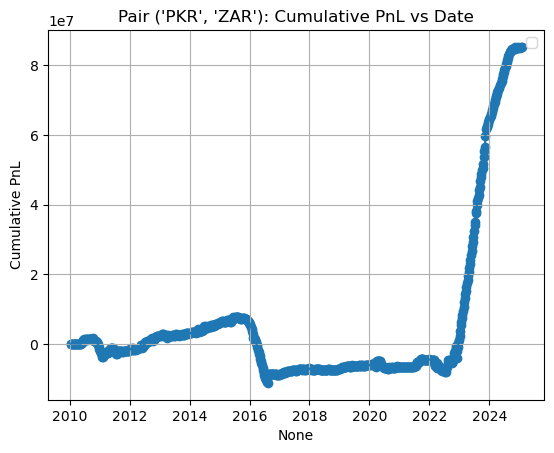

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


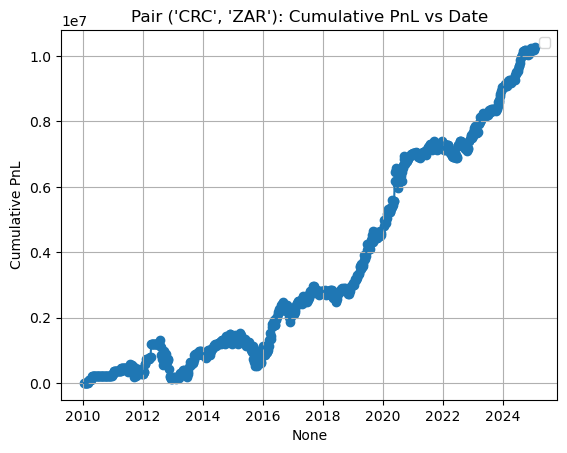

In [152]:
graph_pair('Cumulative PnL')

## Commentary on Cumulative PnL

We see a relatively consistent realizations for all currencies that are NOT Pakistani. The Pakistani currency seems to have some idiosyncratic event that causes spreads to deviate massively during a short period. 

To observe what causes this massive PnL swing, we will observe a histogram of PnL and a graph of signal generation.

# Signal Generation vs Date

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


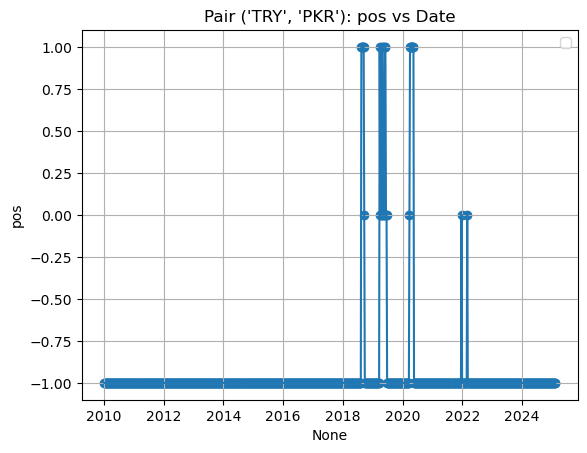

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


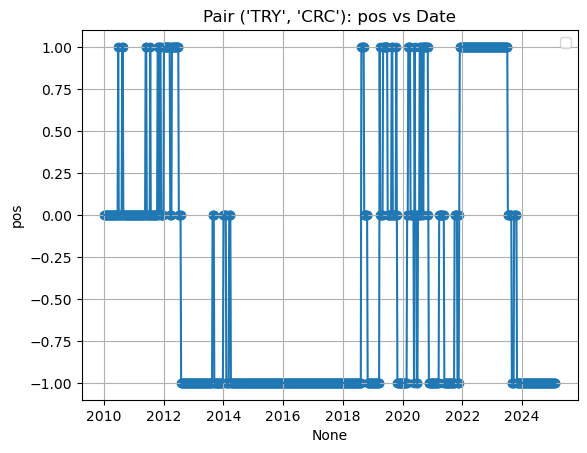

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


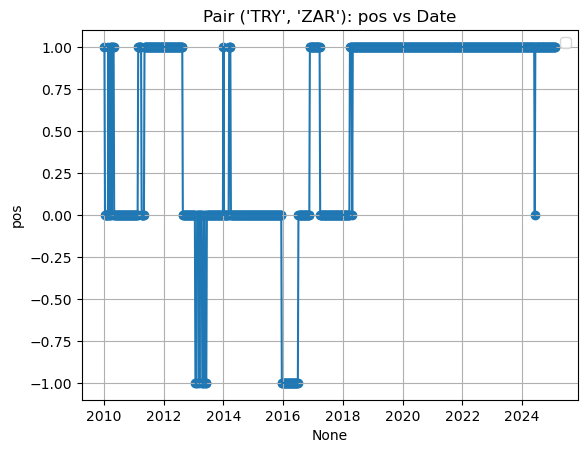

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


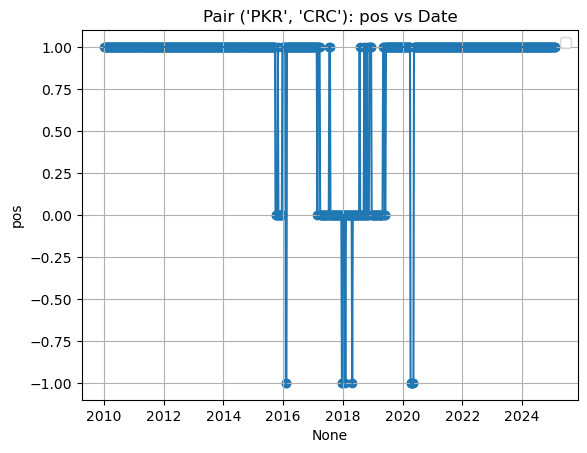

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


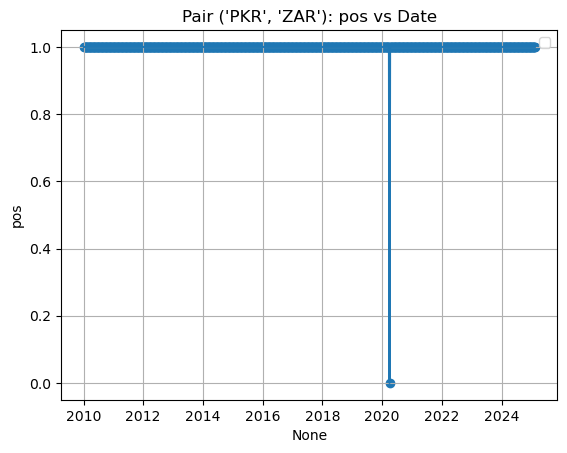

C:\Users\vince\AppData\Local\Temp\ipykernel_9700\258685980.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


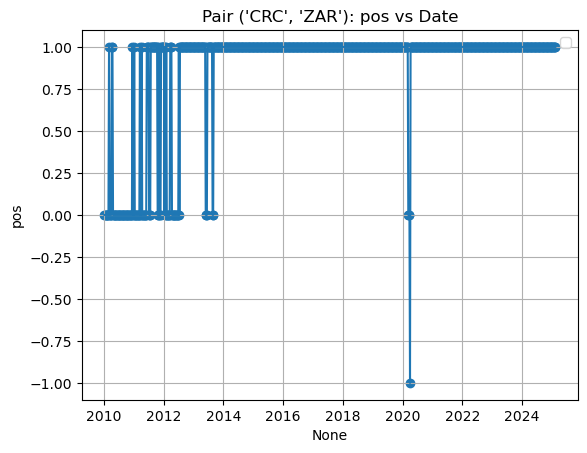

In [153]:
graph_pair('pos')

## Signal Generation Commentary

As we expected, the signals in the PKR pairings are definitely very one-sided. There is a consistent signal to lend PKR due to higher rates. We see that the fx rate change never accounts for this spread until when we see a massive PnL swing around 2023. This can be accounted for by an adjustment in fx rate for PKR. 

Another note of interest is we see consistent batches of dates with buy/sell signals, indicating a lack of adjustment of rates given relative credibility of the central banks in each of the countries stays relatively consistent. 

# PnL Histograms

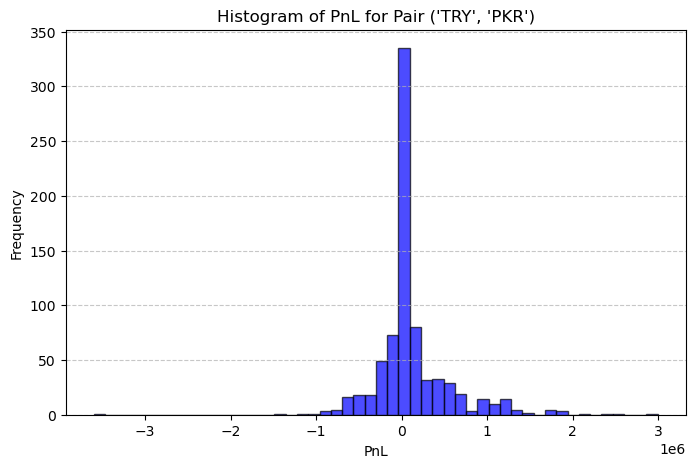

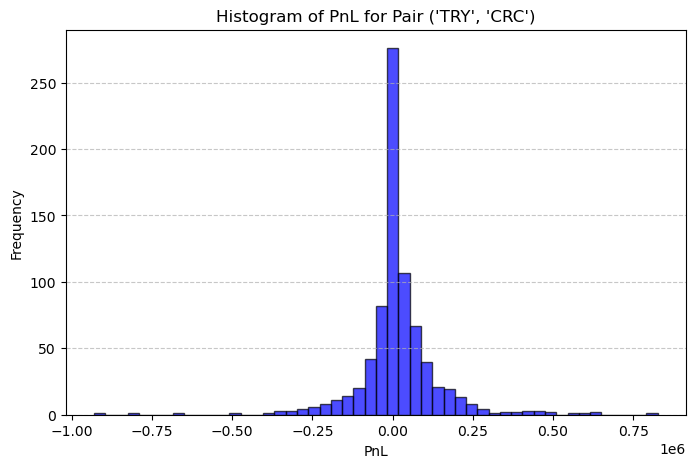

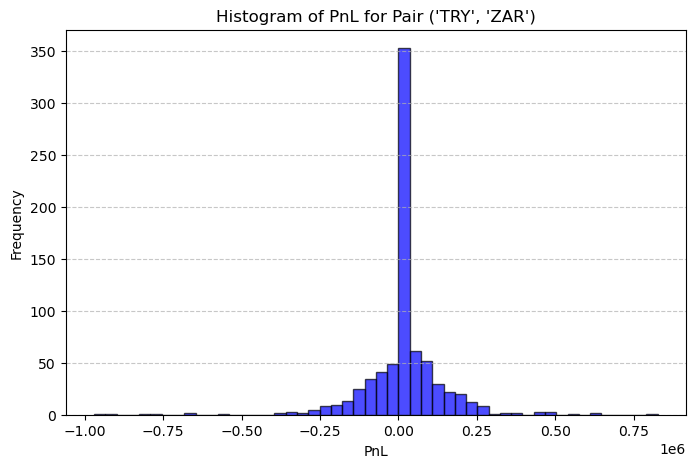

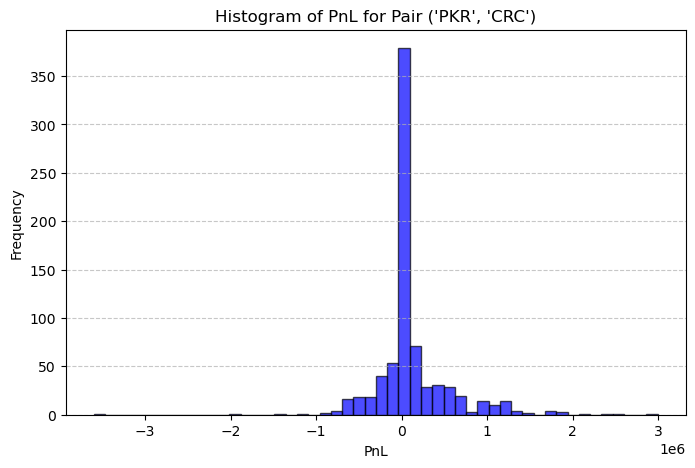

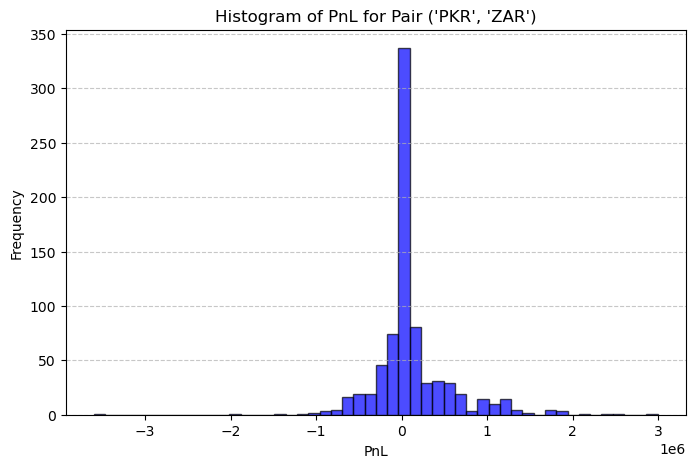

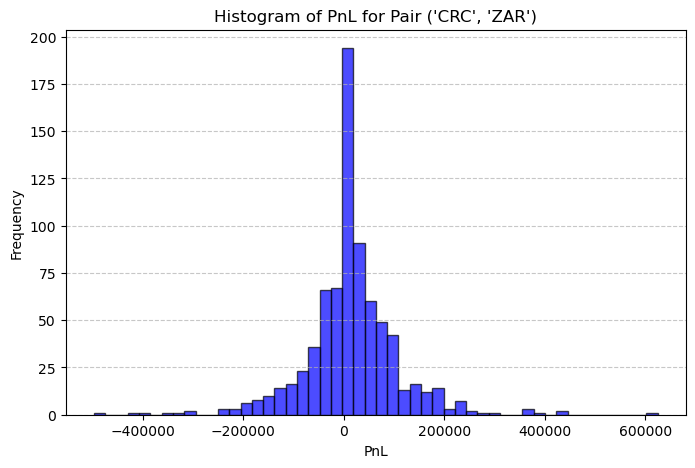

In [156]:
graph_pair('PnL', histogram=True)

## PnL Commentary:

Interestingly, the histograms do not display much skew, even in the Pakistani plots. The means also do not deviate far from 0. As a result, we can say the strategy may be making money from a few outliers in performance or perhaps the mean PnL is statistically significantly positive.

# PnL correlations

In [159]:
all_pairs_of_pairs = list(combinations(all_pairs, 2))

for p1, p2 in all_pairs_of_pairs:
    pnl1 = res_dict[p1]['PnL'].dropna()
    pnl2 = res_dict[p2]['PnL'].dropna()

    corr = pnl1.corr(pnl2)
    print(f'Correlation between {p1} and {p2} is: {corr}')

Correlation between ('TRY', 'PKR') and ('TRY', 'CRC') is: 0.13757249934220012
Correlation between ('TRY', 'PKR') and ('TRY', 'ZAR') is: 0.1406906279106493
Correlation between ('TRY', 'PKR') and ('PKR', 'CRC') is: 0.9768154100537257
Correlation between ('TRY', 'PKR') and ('PKR', 'ZAR') is: 0.9804699537485309
Correlation between ('TRY', 'PKR') and ('CRC', 'ZAR') is: 0.07175777939354644
Correlation between ('TRY', 'CRC') and ('TRY', 'ZAR') is: 0.6568441682650581
Correlation between ('TRY', 'CRC') and ('PKR', 'CRC') is: 0.13582253395848704
Correlation between ('TRY', 'CRC') and ('PKR', 'ZAR') is: 0.13552551595842063
Correlation between ('TRY', 'CRC') and ('CRC', 'ZAR') is: 0.5367299901728791
Correlation between ('TRY', 'ZAR') and ('PKR', 'CRC') is: 0.139517538420382
Correlation between ('TRY', 'ZAR') and ('PKR', 'ZAR') is: 0.1278492464269922
Correlation between ('TRY', 'ZAR') and ('CRC', 'ZAR') is: 0.18567748165429346
Correlation between ('PKR', 'CRC') and ('PKR', 'ZAR') is: 0.987264406404

As we suspected and observed, the correlations between all of the pairings that contain PKR in both was relatively high. Other than that, the TRY, CAC and TRY, ZAR was the highest at 0.656. However, we do not see high values in other pairings. This suggests a fluky occurence but is still worth investigating with ~800 data points in each series.

# Final Analysis:

Despite promising results from our strategy in some currency pairs there are some obvious risks. 

## True PnL

From our observed PnL histograms, it is uncertain whether the strategy is consistently making money given modes near 0 and large variation (is the mean truly larger than 0?).

## Market Risk

The market addage that describes a lot of our trading is "The market can stay irrational longer than you can stay solvent." We notice a consistent signal in many of the currencies but inconsistent PnL on these signals (espically with PKR) because there could still be basis in swap spread and fx spread that does not realize within the week. With the PKR trade, we don't make money until 2023 despite starting our strategy in 2010. Our investors would have pulled their funding a long time ago, before we could realize our 8 million in total PnL in 2023. 

In addition, we assume a consistent coupon spread of under 50bps which may not apply for many currency pairs. This assumption could be dangerous in trading 2 countries with different central bank credibility. 